Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
 frog  bird  deer   car


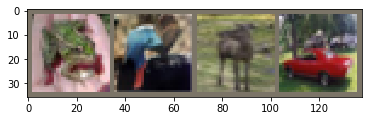

In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [2]:
# ================================================= Flexible Layer ================================================================================

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = kernel_size
        stride = stride
        padding = padding
        dilation = dilation
        super(FlexiLayer, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)
        
        
        self.threshold1 = nn.parameter.Parameter(torch.randn((100, 64, 30, 30)), requires_grad=True)
            
    def forward(self, t):
        
        t_1 = F.relu(F.conv2d(t, self.weight)) # get convolution result
        t_2 = F.max_pool2d(t, kernel_size=self.kernel_size, stride=1) # get max result with the same kernel size
        #t_2 = torch.cat((t_2, t_2, t_2), 1)
        m = nn.Sigmoid()
        cond = torch.sub(t_2, self.threshold1)
        t_2 = m(cond*50)*t_2 # 
        t_1 = m(cond*(-50))*t_1 # 
        t = torch.add(t_2, t_1)
        #t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        return t

In [3]:
# ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16,self).__init__()

    self.block1 = nn.Sequential(
                  nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  #nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.3))

    self.block2 = nn.Sequential(
                  nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.4))

    self.block3 = nn.Sequential(
                  nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.4))

    self.block4 = nn.Sequential(
                  nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2) ,
                  nn.Dropout2d(0.4))

    self.block5 = nn.Sequential(
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.5) )

    self.fc =     nn.Sequential(
                  nn.Linear(512,100),
                  nn.Dropout(0.5),
                  nn.BatchNorm1d(100),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  nn.Linear(100,10), )
                  
                  


  def forward(self,x):
    out = self.block1(x)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = out.view(out.size(0),-1)
    out = self.fc(out)

    return out

In [4]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)


# ======================== Function to get the test accuracy ===============================================================================
def test():
  correct = 0
  total = 0
  model.train(False)
  with torch.no_grad():
    for i,(images,labels)in enumerate(testloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = model(Variable(images))
      labels = Variable(labels)
      _,predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted.eq(labels)).sum().item()
    print('Test accuracy: %d %%' % (
  100 * correct / total))
  return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 200  # Train for 200 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs):
  model.train(True)
  schedule.step()
  epoch_loss  = 0
  i_count = 0
  acc_total = 0
  for i,(images,labels) in enumerate(trainloader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    labels = Variable(labels)
    optimizer.zero_grad()
    outputs = model(Variable(images))
    loss = criterion(outputs,labels)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    _,predicted = outputs.max(1)
    denom = labels.size(0)
    correct = predicted.eq(labels).sum().item()
    acc = 100*(correct/denom)
    acc_total += acc
    i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
  train_loss.append(epoch_loss)
  print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
  print('\n')
  test_acc = test()      # Print the test accuracy per epoch
  test_accuracy.append(test_acc)
  
  if(epoch%50 == 0):       # Save the model every 50 epoch
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    path = './VGG16-flex-v5-block1-' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    torch.save(state,path)


/home/mlavrov/anaconda3/envs/meng/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch:  0   Loss:  1081.6267292499542   Train Accuracy : 18.44


Test accuracy: 19 %
Epoch:  1   Loss:  944.1387813091278   Train Accuracy : 28.34


Test accuracy: 31 %
Epoch:  2   Loss:  880.7280458211899   Train Accuracy : 33.398


Test accuracy: 38 %
Epoch:  3   Loss:  835.5594223737717   Train Accuracy : 37.492


Test accuracy: 45 %
Epoch:  4   Loss:  799.6720504760742   Train Accuracy : 40.882


Test accuracy: 48 %
Epoch:  5   Loss:  764.2561674118042   Train Accuracy : 44.548


Test accuracy: 53 %
Epoch:  6   Loss:  733.0517596006393   Train Accuracy : 47.968


Test accuracy: 56 %
Epoch:  7   Loss:  698.0382008552551   Train Accuracy : 51.28


Test accuracy: 58 %
Epoch:  8   Loss:  665.888821721077   Train Accuracy : 54.118


Test accuracy: 61 %
Epoch:  9   Loss:  638.1468638181686   Train Accuracy : 56.622


Test accuracy: 64 %
Epoch:  10   Loss:  609.6415465474129   Train Accuracy : 59.324


Test accuracy: 66 %
Epoch:  11   Loss:  587.7886090278625   Train Accuracy : 61.212


T

In [5]:
#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Test accuracy: 90 %
90.59
Accuracy of plane : 97 %
Accuracy of   car : 96 %
Accuracy of  bird : 86 %
Accuracy of   cat : 72 %
Accuracy of  deer : 95 %
Accuracy of   dog : 84 %
Accuracy of  frog : 94 %
Accuracy of horse : 96 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %
